# Домашнее задание "Современные сверточные архитектуры"

Задание 1: Возьмите датасет

1.Обучите на нём модели ResNet 18 и VGG 16 с нуля (5-10 эпох)

2.Обучите на нём модели ResNet 18 и VGG 16 с использованием fine-tuning (5-10 эпох)

3.Добавьте аугментацию данных к пункту 2. Сравните качество всех 3 полученных подходов

Задание 2* (дополнительное и необязательное):  Примените fine-tuning ResNet 18 к Fashion Mnist. Удалось ли увидеть резкое увеличение качества?

In [1]:
conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn
import torchvision as tv
! pip install torch-summary
from torchsummary import summary
import time

In [4]:
torch.cuda.is_available()

False

In [5]:
data_transforms = {
    'train': tv.transforms.Compose([
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': tv.transforms.Compose([
        tv.transforms.Resize(256),
        tv.transforms.CenterCrop(224),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
import os
BATCH_SIZE = 256
data_dir = 'hymenoptera_data'
image_datasets = {x: tv.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

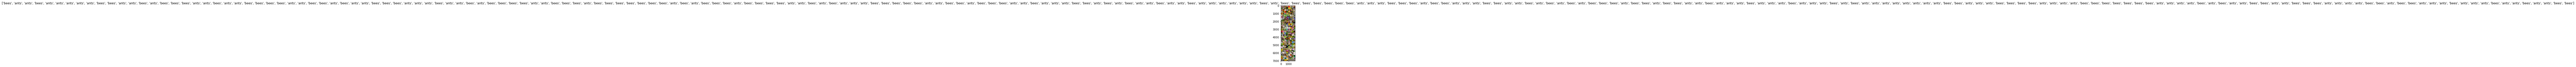

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = tv.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    net.eval()
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [25]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
                (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

# ResNet18  (pretrained=False)

In [9]:
model_resnet = tv.models.resnet18(pretrained=False)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
train(model_resnet, dataloaders['train'], dataloaders['val'], optimizer_ft, 5)

Step. time since epoch: 50.013. Train acc: 0.000. Train Loss: 1508.043
epoch 1, loss 6.1805, train acc 0.000, test acc 0.542, time 60.7 sec
Step. time since epoch: 32.515. Train acc: 0.496. Train Loss: 763.980
epoch 2, loss 3.1311, train acc 0.496, test acc 0.458, time 42.9 sec
Step. time since epoch: 22.632. Train acc: 0.504. Train Loss: 31084312.000
epoch 3, loss 127394.7213, train acc 0.504, test acc 0.458, time 31.2 sec
Step. time since epoch: 23.203. Train acc: 0.504. Train Loss: nan
epoch 4, loss nan, train acc 0.504, test acc 0.458, time 33.2 sec
Step. time since epoch: 24.033. Train acc: 0.504. Train Loss: nan
epoch 5, loss nan, train acc 0.504, test acc 0.458, time 33.9 sec


# vgg16 (pretrained=False)

In [11]:
model_vgg = tv.models.vgg16(pretrained=False)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

In [12]:
train(model_vgg, dataloaders['train'], dataloaders['val'], optimizer_ft, 5)

Step. time since epoch: 1318.677. Train acc: 0.000. Train Loss: 1687.099
epoch 1, loss 6.9143, train acc 0.000, test acc 0.542, time 1544.1 sec
Step. time since epoch: 1177.947. Train acc: 0.496. Train Loss: 642.666
epoch 2, loss 2.6339, train acc 0.496, test acc 0.458, time 1352.1 sec
Step. time since epoch: 691.465. Train acc: 0.504. Train Loss: 17309127147520.000
epoch 3, loss 70939045686.5574, train acc 0.504, test acc 0.458, time 773.1 sec
Step. time since epoch: 348.035. Train acc: 0.504. Train Loss: nan
epoch 4, loss nan, train acc 0.504, test acc 0.458, time 406.8 sec
Step. time since epoch: 184.335. Train acc: 0.504. Train Loss: nan
epoch 5, loss nan, train acc 0.504, test acc 0.458, time 245.2 sec


# resnet18(pretrained=True)

In [14]:
model_resnet = tv.models.resnet18(pretrained=True)

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


In [15]:
for param in model_resnet.parameters():
    param.requires_grad = False

In [22]:
model_resnet.fc

Linear(in_features=512, out_features=10, bias=True)

In [16]:
model_resnet.fc = nn.Linear(in_features=512, out_features=10)

In [17]:
print("Params to learn:")
params_to_update = []
for name,param in model_resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [20]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [21]:
train(model_resnet, dataloaders['train'], dataloaders['val'], optimizer_ft, 5)

Step. time since epoch: 8.843. Train acc: 0.525. Train Loss: 4086.816
epoch 1, loss 16.7492, train acc 0.525, test acc 0.928, time 16.0 sec
Step. time since epoch: 8.504. Train acc: 0.906. Train Loss: 363.249
epoch 2, loss 1.4887, train acc 0.906, test acc 0.614, time 15.5 sec
Step. time since epoch: 8.362. Train acc: 0.615. Train Loss: 4202.022
epoch 3, loss 17.2214, train acc 0.615, test acc 0.778, time 15.5 sec
Step. time since epoch: 8.575. Train acc: 0.754. Train Loss: 1949.940
epoch 4, loss 7.9916, train acc 0.754, test acc 0.941, time 15.7 sec
Step. time since epoch: 8.449. Train acc: 0.918. Train Loss: 412.587
epoch 5, loss 1.6909, train acc 0.918, test acc 0.739, time 15.6 sec


# vgg16(pretrained=True)

In [23]:
model_vgg = tv.models.vgg16(pretrained=True)

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\User/.cache\torch\hub\checkpoints\vgg16-397923af.pth


In [24]:
for param in model_vgg.parameters():
    param.requires_grad = False

In [26]:
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=10)

In [27]:
print("Params to learn:")
params_to_update = []
for name,param in model_vgg.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [28]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [29]:
train(model_vgg, dataloaders['train'], dataloaders['val'], optimizer_ft, 5)  

Step. time since epoch: 356.633. Train acc: 0.061. Train Loss: 590.129
epoch 1, loss 2.4186, train acc 0.061, test acc 0.974, time 421.1 sec
Step. time since epoch: 240.230. Train acc: 0.922. Train Loss: 131.976
epoch 2, loss 0.5409, train acc 0.922, test acc 0.961, time 272.1 sec
Step. time since epoch: 267.652. Train acc: 0.939. Train Loss: 132.846
epoch 3, loss 0.5444, train acc 0.939, test acc 0.954, time 299.5 sec
Step. time since epoch: 290.932. Train acc: 0.930. Train Loss: 150.778
epoch 4, loss 0.6179, train acc 0.930, test acc 0.967, time 320.5 sec
Step. time since epoch: 246.113. Train acc: 0.951. Train Loss: 188.381
epoch 5, loss 0.7721, train acc 0.951, test acc 0.967, time 283.3 sec


# resnet18(pretrained=True) + augmentation

In [10]:
! pip install -U albumentations
from scipy import misc
from PIL import Image
from torchvision import transforms

Requirement already up-to-date: albumentations in c:\users\user\anaconda3\lib\site-packages (1.3.0)


In [11]:
! pip install -U typing_extensions

Requirement already up-to-date: typing_extensions in c:\users\user\anaconda3\lib\site-packages (4.4.0)


In [11]:
# ! conda install -c conda-forge imgaug
! conda install -c conda-forge albumentations

^C


In [12]:
#from typing_extensions import ParamSpec, Concatenate
#from typing_extensions import Concatenate
import albumentations as alb

In [14]:
data_transforms_aug = {
    'train': tv.transforms.Compose([
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.RandomHorizontalFlip(), 
        tv.transforms.ColorJitter(hue=.05, saturation=.05),
        tv.transforms.RandomRotation(degrees=90),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': tv.transforms.Compose([
        tv.transforms.Resize(256),
        tv.transforms.CenterCrop(224),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [15]:
image_datasets_aug = {x: tv.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_aug[x])
                  for x in ['train', 'val']}
dataloaders_aug = {x: torch.utils.data.DataLoader(image_datasets_aug[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes_aug = {x: len(image_datasets_aug[x]) for x in ['train', 'val']}
class_names_aug = image_datasets_aug['train'].classes

In [16]:
model_resnet = tv.models.resnet18(pretrained=True)

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
for param in model_resnet.parameters():
    param.requires_grad = False

In [18]:
model_resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [19]:
model_resnet.fc = nn.Linear(in_features=512, out_features=10)

In [20]:
print("Params to learn:")
params_to_update = []
for name,param in model_resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [21]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [28]:
train(model_resnet, dataloaders_aug['train'], dataloaders_aug['val'], optimizer_ft, 5)

Step. time since epoch: 2.972. Train acc: 0.250. Train Loss: 7.467
Step. time since epoch: 3.144. Train acc: 1.000. Train Loss: 0.200
Step. time since epoch: 3.317. Train acc: 0.500. Train Loss: 2.736
Step. time since epoch: 3.455. Train acc: 0.500. Train Loss: 4.104
Step. time since epoch: 3.576. Train acc: 1.000. Train Loss: 0.010
Step. time since epoch: 3.704. Train acc: 0.500. Train Loss: 4.168
Step. time since epoch: 3.842. Train acc: 0.500. Train Loss: 5.398
Step. time since epoch: 3.950. Train acc: 0.750. Train Loss: 1.636
Step. time since epoch: 4.068. Train acc: 0.250. Train Loss: 17.826
Step. time since epoch: 4.212. Train acc: 0.250. Train Loss: 18.067
Step. time since epoch: 4.334. Train acc: 0.500. Train Loss: 4.480
Step. time since epoch: 4.454. Train acc: 0.750. Train Loss: 8.321
Step. time since epoch: 4.565. Train acc: 0.500. Train Loss: 6.495
Step. time since epoch: 4.683. Train acc: 0.750. Train Loss: 2.729
Step. time since epoch: 4.800. Train acc: 0.500. Train Loss:

epoch 2, loss 0.7007, train acc 0.844, test acc 0.915, time 18.6 sec
Step. time since epoch: 2.739. Train acc: 1.000. Train Loss: 0.425
Step. time since epoch: 3.266. Train acc: 1.000. Train Loss: 0.135
Step. time since epoch: 3.526. Train acc: 0.750. Train Loss: 11.081
Step. time since epoch: 3.689. Train acc: 1.000. Train Loss: 0.007
Step. time since epoch: 3.812. Train acc: 1.000. Train Loss: 0.169
Step. time since epoch: 3.936. Train acc: 0.750. Train Loss: 3.297
Step. time since epoch: 4.059. Train acc: 0.750. Train Loss: 0.991
Step. time since epoch: 4.182. Train acc: 0.750. Train Loss: 1.724
Step. time since epoch: 4.304. Train acc: 0.750. Train Loss: 1.748
Step. time since epoch: 4.436. Train acc: 1.000. Train Loss: 0.001
Step. time since epoch: 4.562. Train acc: 0.750. Train Loss: 5.238
Step. time since epoch: 4.684. Train acc: 1.000. Train Loss: 0.003
Step. time since epoch: 4.808. Train acc: 0.750. Train Loss: 1.242
Step. time since epoch: 4.914. Train acc: 0.750. Train Loss

Step. time since epoch: 9.716. Train acc: 0.750. Train Loss: 3.840
epoch 4, loss 0.5365, train acc 0.852, test acc 0.915, time 17.2 sec
Step. time since epoch: 2.565. Train acc: 1.000. Train Loss: 0.012
Step. time since epoch: 2.711. Train acc: 0.750. Train Loss: 0.922
Step. time since epoch: 2.889. Train acc: 0.750. Train Loss: 1.324
Step. time since epoch: 3.061. Train acc: 1.000. Train Loss: 0.007
Step. time since epoch: 3.213. Train acc: 1.000. Train Loss: 0.001
Step. time since epoch: 3.376. Train acc: 0.750. Train Loss: 5.589
Step. time since epoch: 3.494. Train acc: 0.750. Train Loss: 10.445
Step. time since epoch: 3.604. Train acc: 1.000. Train Loss: 0.001
Step. time since epoch: 3.715. Train acc: 0.750. Train Loss: 1.027
Step. time since epoch: 3.825. Train acc: 1.000. Train Loss: 0.002
Step. time since epoch: 3.938. Train acc: 1.000. Train Loss: 0.022
Step. time since epoch: 4.045. Train acc: 1.000. Train Loss: 0.000
Step. time since epoch: 4.151. Train acc: 1.000. Train Loss

# vgg16(pretrained=True) + augmentation

In [29]:
model_vgg = tv.models.vgg16(pretrained=True)

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
for param in model_vgg.parameters():
    param.requires_grad = False

In [31]:
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=10)

In [32]:
print("Params to learn:")
params_to_update = []
for name,param in model_vgg.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [33]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [34]:
train(model_vgg, dataloaders_aug['train'], dataloaders_aug['val'], optimizer_ft, 5)

Step. time since epoch: 3.518. Train acc: 0.000. Train Loss: 10.413
Step. time since epoch: 4.135. Train acc: 0.250. Train Loss: 8.209
Step. time since epoch: 4.713. Train acc: 0.000. Train Loss: 10.529
Step. time since epoch: 5.243. Train acc: 1.000. Train Loss: 1.224
Step. time since epoch: 5.788. Train acc: 0.000. Train Loss: 21.529
Step. time since epoch: 6.325. Train acc: 1.000. Train Loss: 0.319
Step. time since epoch: 6.867. Train acc: 0.500. Train Loss: 14.016
Step. time since epoch: 7.387. Train acc: 0.750. Train Loss: 1.657
Step. time since epoch: 7.908. Train acc: 0.500. Train Loss: 2.508
Step. time since epoch: 8.450. Train acc: 0.750. Train Loss: 3.554
Step. time since epoch: 8.968. Train acc: 1.000. Train Loss: 0.002
Step. time since epoch: 9.541. Train acc: 1.000. Train Loss: 0.047
Step. time since epoch: 10.122. Train acc: 0.750. Train Loss: 2.163
Step. time since epoch: 10.680. Train acc: 0.750. Train Loss: 10.512
Step. time since epoch: 11.263. Train acc: 1.000. Train

Step. time since epoch: 34.504. Train acc: 1.000. Train Loss: 0.136
Step. time since epoch: 35.030. Train acc: 1.000. Train Loss: 0.000
epoch 2, loss 0.8362, train acc 0.852, test acc 0.915, time 58.3 sec
Step. time since epoch: 3.180. Train acc: 0.750. Train Loss: 3.233
Step. time since epoch: 3.724. Train acc: 0.750. Train Loss: 1.267
Step. time since epoch: 4.245. Train acc: 1.000. Train Loss: 0.281
Step. time since epoch: 4.795. Train acc: 0.750. Train Loss: 1.700
Step. time since epoch: 5.312. Train acc: 1.000. Train Loss: 0.047
Step. time since epoch: 5.842. Train acc: 0.750. Train Loss: 0.980
Step. time since epoch: 6.368. Train acc: 0.750. Train Loss: 24.001
Step. time since epoch: 6.916. Train acc: 1.000. Train Loss: 0.010
Step. time since epoch: 7.441. Train acc: 0.750. Train Loss: 3.361
Step. time since epoch: 7.989. Train acc: 1.000. Train Loss: 0.010
Step. time since epoch: 8.506. Train acc: 0.750. Train Loss: 2.694
Step. time since epoch: 9.044. Train acc: 1.000. Train Lo

Step. time since epoch: 32.543. Train acc: 1.000. Train Loss: 0.006
Step. time since epoch: 33.081. Train acc: 0.750. Train Loss: 4.359
Step. time since epoch: 33.587. Train acc: 1.000. Train Loss: 0.002
Step. time since epoch: 34.105. Train acc: 1.000. Train Loss: 0.207
Step. time since epoch: 34.640. Train acc: 1.000. Train Loss: 0.367
epoch 4, loss 0.9256, train acc 0.869, test acc 0.961, time 58.1 sec
Step. time since epoch: 3.345. Train acc: 0.750. Train Loss: 4.319
Step. time since epoch: 3.923. Train acc: 1.000. Train Loss: 0.012
Step. time since epoch: 4.446. Train acc: 0.500. Train Loss: 24.112
Step. time since epoch: 4.986. Train acc: 1.000. Train Loss: 0.000
Step. time since epoch: 5.513. Train acc: 0.750. Train Loss: 1.161
Step. time since epoch: 6.044. Train acc: 1.000. Train Loss: 0.000
Step. time since epoch: 6.567. Train acc: 1.000. Train Loss: 0.000
Step. time since epoch: 7.118. Train acc: 0.750. Train Loss: 6.453
Step. time since epoch: 7.652. Train acc: 1.000. Train

Лучшим результатом оказалась сеть vgg16 pretrained = true без аугментации. Странно, так как лучшие результаты я ожидал от моделей с аугментацией. Хотя, vgg16 с аугментацией на 2 месте.

# Fine-tuning ResNet 18 Fashion Mnist

In [43]:
data_transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.RandomResizedCrop(224),
    tv.transforms.CenterCrop(224),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(degrees=90),
    tv.transforms.ToTensor()
])

BATCH_SIZE = 256
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=data_transforms, download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=data_transforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [44]:
model_resnet = tv.models.resnet18(pretrained=True)

In [45]:
for param in model_resnet.parameters():
    param.requires_grad = False

In [46]:
model_resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

In [47]:
model_resnet.fc = nn.Linear(in_features=512, out_features=1000)

In [48]:
print("Params to learn:")
params_to_update = []
for name,param in model_resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [49]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [50]:
train(model_resnet, train_iter, test_iter, optimizer_ft, 5)

Step. time since epoch: 6.081. Train acc: 0.000. Train Loss: 1759.590
Step. time since epoch: 12.252. Train acc: 0.152. Train Loss: 650.954
Step. time since epoch: 18.368. Train acc: 0.191. Train Loss: 1286.135
Step. time since epoch: 24.830. Train acc: 0.246. Train Loss: 2403.913
Step. time since epoch: 31.388. Train acc: 0.105. Train Loss: 3981.875
Step. time since epoch: 37.686. Train acc: 0.125. Train Loss: 6677.721
Step. time since epoch: 43.850. Train acc: 0.227. Train Loss: 8216.759
Step. time since epoch: 50.057. Train acc: 0.207. Train Loss: 12563.689
Step. time since epoch: 56.568. Train acc: 0.121. Train Loss: 15565.336
Step. time since epoch: 63.040. Train acc: 0.102. Train Loss: 24137.412
Step. time since epoch: 69.814. Train acc: 0.090. Train Loss: 31958.248
Step. time since epoch: 76.641. Train acc: 0.145. Train Loss: 26225.557
Step. time since epoch: 83.292. Train acc: 0.164. Train Loss: 30318.227
Step. time since epoch: 89.935. Train acc: 0.078. Train Loss: 32701.172
S

Step. time since epoch: 775.176. Train acc: 0.445. Train Loss: 3050.109
Step. time since epoch: 781.468. Train acc: 0.355. Train Loss: 5005.519
Step. time since epoch: 787.824. Train acc: 0.473. Train Loss: 2532.627
Step. time since epoch: 794.036. Train acc: 0.418. Train Loss: 3306.918
Step. time since epoch: 801.375. Train acc: 0.430. Train Loss: 3893.335
Step. time since epoch: 809.037. Train acc: 0.379. Train Loss: 4223.780
Step. time since epoch: 815.432. Train acc: 0.500. Train Loss: 2470.883
Step. time since epoch: 822.022. Train acc: 0.422. Train Loss: 2696.965
Step. time since epoch: 828.219. Train acc: 0.480. Train Loss: 2431.667
Step. time since epoch: 834.324. Train acc: 0.414. Train Loss: 2442.026
Step. time since epoch: 840.844. Train acc: 0.551. Train Loss: 1820.154
Step. time since epoch: 847.262. Train acc: 0.484. Train Loss: 2486.828
Step. time since epoch: 853.446. Train acc: 0.512. Train Loss: 2077.350
Step. time since epoch: 860.239. Train acc: 0.445. Train Loss: 2

Step. time since epoch: 1482.195. Train acc: 0.410. Train Loss: 3048.952
Step. time since epoch: 1488.291. Train acc: 0.441. Train Loss: 2513.985
Step. time since epoch: 1494.818. Train acc: 0.461. Train Loss: 2444.844
Step. time since epoch: 1501.203. Train acc: 0.512. Train Loss: 1943.358
Step. time since epoch: 1507.714. Train acc: 0.473. Train Loss: 2753.850
Step. time since epoch: 1513.977. Train acc: 0.496. Train Loss: 2535.819
Step. time since epoch: 1521.370. Train acc: 0.539. Train Loss: 1835.623
Step. time since epoch: 1523.892. Train acc: 0.500. Train Loss: 776.300
epoch 1, loss 21.9851, train acc 0.392, test acc 0.444, time 1758.4 sec
Step. time since epoch: 5.938. Train acc: 0.434. Train Loss: 2762.793
Step. time since epoch: 11.785. Train acc: 0.434. Train Loss: 2380.114
Step. time since epoch: 17.731. Train acc: 0.570. Train Loss: 1898.023
Step. time since epoch: 23.676. Train acc: 0.523. Train Loss: 2352.685
Step. time since epoch: 29.738. Train acc: 0.457. Train Loss: 

Step. time since epoch: 644.082. Train acc: 0.367. Train Loss: 4327.037
Step. time since epoch: 650.159. Train acc: 0.398. Train Loss: 4716.821
Step. time since epoch: 656.281. Train acc: 0.270. Train Loss: 5772.036
Step. time since epoch: 662.250. Train acc: 0.473. Train Loss: 1972.617
Step. time since epoch: 668.176. Train acc: 0.434. Train Loss: 3138.255
Step. time since epoch: 674.046. Train acc: 0.359. Train Loss: 4500.397
Step. time since epoch: 679.938. Train acc: 0.414. Train Loss: 3068.820
Step. time since epoch: 686.051. Train acc: 0.406. Train Loss: 2922.548
Step. time since epoch: 692.284. Train acc: 0.441. Train Loss: 2824.642
Step. time since epoch: 698.151. Train acc: 0.504. Train Loss: 2571.076
Step. time since epoch: 704.075. Train acc: 0.391. Train Loss: 2785.881
Step. time since epoch: 710.114. Train acc: 0.414. Train Loss: 2974.753
Step. time since epoch: 716.039. Train acc: 0.398. Train Loss: 3612.542
Step. time since epoch: 722.048. Train acc: 0.430. Train Loss: 3

Step. time since epoch: 1341.929. Train acc: 0.461. Train Loss: 2387.788
Step. time since epoch: 1347.842. Train acc: 0.512. Train Loss: 1876.997
Step. time since epoch: 1354.313. Train acc: 0.324. Train Loss: 3406.241
Step. time since epoch: 1360.518. Train acc: 0.344. Train Loss: 3165.062
Step. time since epoch: 1368.858. Train acc: 0.453. Train Loss: 2647.981
Step. time since epoch: 1376.504. Train acc: 0.469. Train Loss: 3239.065
Step. time since epoch: 1383.046. Train acc: 0.480. Train Loss: 3276.784
Step. time since epoch: 1389.793. Train acc: 0.398. Train Loss: 3557.365
Step. time since epoch: 1396.710. Train acc: 0.395. Train Loss: 3947.198
Step. time since epoch: 1402.920. Train acc: 0.469. Train Loss: 3079.471
Step. time since epoch: 1409.961. Train acc: 0.453. Train Loss: 2302.781
Step. time since epoch: 1416.007. Train acc: 0.414. Train Loss: 2585.806
Step. time since epoch: 1422.893. Train acc: 0.426. Train Loss: 2700.594
Step. time since epoch: 1429.700. Train acc: 0.473.

Step. time since epoch: 608.234. Train acc: 0.512. Train Loss: 3568.695
Step. time since epoch: 614.179. Train acc: 0.449. Train Loss: 2933.688
Step. time since epoch: 620.027. Train acc: 0.430. Train Loss: 5393.001
Step. time since epoch: 626.071. Train acc: 0.434. Train Loss: 4220.686
Step. time since epoch: 631.924. Train acc: 0.457. Train Loss: 3976.847
Step. time since epoch: 637.744. Train acc: 0.410. Train Loss: 5167.577
Step. time since epoch: 643.553. Train acc: 0.496. Train Loss: 3304.234
Step. time since epoch: 649.474. Train acc: 0.504. Train Loss: 2150.808
Step. time since epoch: 655.375. Train acc: 0.273. Train Loss: 4784.849
Step. time since epoch: 661.306. Train acc: 0.402. Train Loss: 2388.026
Step. time since epoch: 667.179. Train acc: 0.438. Train Loss: 2862.051
Step. time since epoch: 673.410. Train acc: 0.480. Train Loss: 3065.895
Step. time since epoch: 679.765. Train acc: 0.406. Train Loss: 3563.918
Step. time since epoch: 687.033. Train acc: 0.492. Train Loss: 2

Step. time since epoch: 1305.154. Train acc: 0.457. Train Loss: 1878.849
Step. time since epoch: 1311.364. Train acc: 0.402. Train Loss: 2940.233
Step. time since epoch: 1317.453. Train acc: 0.422. Train Loss: 3047.328
Step. time since epoch: 1323.559. Train acc: 0.336. Train Loss: 4051.518
Step. time since epoch: 1329.713. Train acc: 0.496. Train Loss: 2327.396
Step. time since epoch: 1336.281. Train acc: 0.371. Train Loss: 4357.391
Step. time since epoch: 1342.429. Train acc: 0.371. Train Loss: 3665.862
Step. time since epoch: 1348.479. Train acc: 0.516. Train Loss: 2293.581
Step. time since epoch: 1354.521. Train acc: 0.457. Train Loss: 3009.564
Step. time since epoch: 1360.612. Train acc: 0.484. Train Loss: 2005.912
Step. time since epoch: 1366.649. Train acc: 0.383. Train Loss: 2827.587
Step. time since epoch: 1372.716. Train acc: 0.375. Train Loss: 2585.522
Step. time since epoch: 1378.779. Train acc: 0.422. Train Loss: 2325.811
Step. time since epoch: 1384.846. Train acc: 0.359.

Step. time since epoch: 553.854. Train acc: 0.504. Train Loss: 1577.480
Step. time since epoch: 559.960. Train acc: 0.508. Train Loss: 1623.658
Step. time since epoch: 566.085. Train acc: 0.520. Train Loss: 1554.085
Step. time since epoch: 572.538. Train acc: 0.465. Train Loss: 1604.521
Step. time since epoch: 578.839. Train acc: 0.574. Train Loss: 1891.238
Step. time since epoch: 585.207. Train acc: 0.539. Train Loss: 1695.064
Step. time since epoch: 591.469. Train acc: 0.543. Train Loss: 1360.900
Step. time since epoch: 597.564. Train acc: 0.414. Train Loss: 2151.937
Step. time since epoch: 603.756. Train acc: 0.578. Train Loss: 1778.991
Step. time since epoch: 610.003. Train acc: 0.543. Train Loss: 1614.856
Step. time since epoch: 616.217. Train acc: 0.496. Train Loss: 3298.198
Step. time since epoch: 622.307. Train acc: 0.531. Train Loss: 2565.429
Step. time since epoch: 628.328. Train acc: 0.531. Train Loss: 2810.675
Step. time since epoch: 634.553. Train acc: 0.430. Train Loss: 2

Step. time since epoch: 1280.235. Train acc: 0.441. Train Loss: 1886.594
Step. time since epoch: 1286.571. Train acc: 0.383. Train Loss: 2489.099
Step. time since epoch: 1292.875. Train acc: 0.379. Train Loss: 2492.407
Step. time since epoch: 1299.113. Train acc: 0.477. Train Loss: 1595.749
Step. time since epoch: 1305.407. Train acc: 0.414. Train Loss: 2477.797
Step. time since epoch: 1311.741. Train acc: 0.344. Train Loss: 4286.944
Step. time since epoch: 1318.304. Train acc: 0.441. Train Loss: 2826.498
Step. time since epoch: 1324.459. Train acc: 0.406. Train Loss: 4352.468
Step. time since epoch: 1330.930. Train acc: 0.418. Train Loss: 4570.796
Step. time since epoch: 1337.494. Train acc: 0.453. Train Loss: 3540.980
Step. time since epoch: 1343.799. Train acc: 0.449. Train Loss: 2324.173
Step. time since epoch: 1350.213. Train acc: 0.387. Train Loss: 2624.482
Step. time since epoch: 1356.870. Train acc: 0.488. Train Loss: 1636.861
Step. time since epoch: 1362.817. Train acc: 0.312.

Step. time since epoch: 482.214. Train acc: 0.613. Train Loss: 1112.208
Step. time since epoch: 488.129. Train acc: 0.504. Train Loss: 1451.801
Step. time since epoch: 493.992. Train acc: 0.492. Train Loss: 1535.566
Step. time since epoch: 499.857. Train acc: 0.566. Train Loss: 1347.285
Step. time since epoch: 505.721. Train acc: 0.516. Train Loss: 1216.243
Step. time since epoch: 511.566. Train acc: 0.547. Train Loss: 1441.463
Step. time since epoch: 517.426. Train acc: 0.465. Train Loss: 1625.849
Step. time since epoch: 523.330. Train acc: 0.484. Train Loss: 1478.458
Step. time since epoch: 529.171. Train acc: 0.449. Train Loss: 1372.922
Step. time since epoch: 535.060. Train acc: 0.520. Train Loss: 1414.431
Step. time since epoch: 540.863. Train acc: 0.469. Train Loss: 1619.269
Step. time since epoch: 546.731. Train acc: 0.543. Train Loss: 1073.806
Step. time since epoch: 552.554. Train acc: 0.512. Train Loss: 1503.774
Step. time since epoch: 558.426. Train acc: 0.484. Train Loss: 1

Step. time since epoch: 1180.594. Train acc: 0.520. Train Loss: 2058.463
Step. time since epoch: 1186.540. Train acc: 0.520. Train Loss: 1510.514
Step. time since epoch: 1192.394. Train acc: 0.441. Train Loss: 1849.682
Step. time since epoch: 1198.224. Train acc: 0.457. Train Loss: 1955.330
Step. time since epoch: 1204.061. Train acc: 0.480. Train Loss: 1732.397
Step. time since epoch: 1209.913. Train acc: 0.449. Train Loss: 2448.866
Step. time since epoch: 1215.669. Train acc: 0.461. Train Loss: 2695.646
Step. time since epoch: 1221.617. Train acc: 0.516. Train Loss: 1917.536
Step. time since epoch: 1227.528. Train acc: 0.566. Train Loss: 1348.324
Step. time since epoch: 1233.565. Train acc: 0.430. Train Loss: 2203.862
Step. time since epoch: 1239.473. Train acc: 0.531. Train Loss: 1396.080
Step. time since epoch: 1245.393. Train acc: 0.445. Train Loss: 1687.426
Step. time since epoch: 1251.310. Train acc: 0.426. Train Loss: 2077.991
Step. time since epoch: 1257.112. Train acc: 0.449.

Видимо своими "Улучшениями" я все испортил. Качество ужасное.